**Libraries**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
import cv2
import pydicom
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import imutils
import os
import re
import sys
from pathlib import Path
import joblib

**Defining file path and Cleaning up column names**

In [ ]:

CLINICAL_PATH = r"D:\Breast_Cancer_Dataset\Clinical_and_Other_Features.xlsx"

def auto_read_with_header_detection(path, lookahead=8):
    raw = pd.read_excel(path, header=None)

    # Detecting header with keywords
    key_re = re.compile(r"staging|tumor|nottingham|grade|\bT\b|\bN\b|\bM\b", re.I)
    header_row = None
    best_score = -1
    for r in range(min(lookahead, len(raw))):
        row_vals = raw.iloc[r].astype(str).fillna("")
        hits = sum(bool(key_re.search(v)) for v in row_vals)
        nonempty = (row_vals != "").sum()
        score = hits * 2 + nonempty
        if hits >= 1 and score > best_score:
            best_score = score
            header_row = r
    if header_row is None:
        header_row = 1 if len(raw) > 1 else 0

    df = pd.read_excel(path, header=header_row)

    # cleaning up column names
    df.columns = (
        df.columns.astype(str)
          .str.replace("\u00A0", " ", regex=False)
          .str.replace(r"\s+", " ", regex=True)
          .str.strip()
    )
    df = df.loc[:, ~df.columns.str.startswith("Unnamed")]
    df = df.loc[:, ~df.columns.duplicated()]
    return df, header_row

clinical, used_header_row = auto_read_with_header_detection(CLINICAL_PATH)
print("Header row used:", used_header_row)
print("Shape:", clinical.shape)
display(clinical.head(2))

**Determining potential target features for cancer staging.
Using tumor staging features and Nottingham grade to locate relevant features**

In [4]:
def find_cols(df, patterns, flags=re.I):
    cols = []
    for c in df.columns.astype(str):
        if any(re.search(p, c, flags) for p in patterns):
            cols.append(c)
    return cols

label_T = find_cols(clinical, [r"staging.*tumor.*\[?t\]?", r"\bT\b"])
label_N = find_cols(clinical, [r"staging.*node.*\[?n\]?", r"\bN\b"])
label_M = find_cols(clinical, [r"staging.*metastasis.*\[?m\]?", r"\bM\b"])
label_NG = find_cols(clinical, [r"nottingham"])

print("T candidates:", label_T)
print("N candidates:", label_N)
print("M candidates:", label_M)
print("Nottingham candidates:", label_NG)

for cand in (label_T[:2] + label_N[:2] + label_M[:2] + label_NG[:2]):
    print(f"\n>> {cand}")
    display(clinical[cand].head(10))

T candidates: ['Staging(Tumor Size)# [T]', 'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy']
N candidates: ['Staging(Nodes)#(Nx replaced by -1)[N]', 'Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy']
M candidates: ['Staging(Metastasis)#(Mx -replaced by -1)[M]', 'Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy']
Nottingham candidates: ['Nottingham grade']

>> Staging(Tumor Size)# [T]


0    NaN
1    2.0
2    2.0
3    2.0
4    1.0
5    2.0
6    1.0
7    1.0
8    1.0
9    2.0
Name: Staging(Tumor Size)# [T], dtype: float64


>> Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy


0    { -1 = TX;  0 = T0;  1 = T1;  2 = T2;  3 = T3;...
1                                                    1
2                                                  NaN
3                                                    1
4                                                  NaN
5                                                    0
6                                                  NaN
7                                                  NaN
8                                                  NaN
9                                                  NaN
Name: Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy, dtype: object


>> Staging(Nodes)#(Nx replaced by -1)[N]


0    NaN
1    1.0
2    0.0
3    1.0
4    0.0
5    1.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Staging(Nodes)#(Nx replaced by -1)[N], dtype: float64


>> Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy


0     { -1 = NX;  0 = N0;  1 = N1;  2 = N2;  3 = N3...
1                                                   -1
2                                                  NaN
3                                                    1
4                                                  NaN
5                                                    0
6                                                  NaN
7                                                  NaN
8                                                  NaN
9                                                  NaN
Name: Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy, dtype: object


>> Staging(Metastasis)#(Mx -replaced by -1)[M]


0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Staging(Metastasis)#(Mx -replaced by -1)[M], dtype: float64


>> Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy


0    { -1 = MX;  0 = M0;  1 = M1;  NA = not applica...
1                                                   -1
2                                                  NaN
3                                                   -1
4                                                  NaN
5                                                   -1
6                                                  NaN
7                                                  NaN
8                                                  NaN
9                                                  NaN
Name: Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy, dtype: object


>> Nottingham grade


0    1=low 2=intermediate 3=high\n
1                                2
2                                3
3                              NaN
4                                2
5                                3
6                              NaN
7                                1
8                                2
9                                3
Name: Nottingham grade, dtype: object

**Manually selecting target feature for prediction from candidates in previous cell.
Selecting desired target column**

In [5]:
TARGET_COL = "Staging(Tumor Size)# [T]"

# Converting to numeric
clinical[TARGET_COL] = pd.to_numeric(clinical[TARGET_COL], errors="coerce")

# Filling in missing values using median
if clinical[TARGET_COL].isna().any():
    clinical[TARGET_COL] = clinical[TARGET_COL].fillna(clinical[TARGET_COL].median())

print(TARGET_COL, clinical[TARGET_COL].dtype)
display(clinical[[TARGET_COL]].head(10))

Staging(Tumor Size)# [T] float64


Staging(Tumor Size)# [T]
0                       2.0
1                       2.0
2                       2.0
3                       2.0
4                       1.0
5                       2.0
6                       1.0
7                       1.0
8                       1.0
9                       2.0

**Removing leakage, ID, and technical features. Summarizing missing data.**

In [6]:
def drop_by_patterns(df, patterns, flags=re.I):
    cols = [c for c in df.columns if any(re.search(p, c, flags) for p in patterns)]
    return df.drop(columns=[c for c in cols if c in df.columns], errors="ignore"), cols

# Dropping potential data leakage features
leakage_patterns = [
    r"Neoadjuvant|Adjuvant|Therapy|Anti-?Her2|Endocrine",
    r"Pathologic response|Pathologic stage",
    r"Recurrence|death|last .*assessment|Age at last contact|Overall Near-?complete Response",
    r"Definitive Surgery|Surgery|Days to Surgery"
]
clinical_wo, dropped_leak = drop_by_patterns(clinical, leakage_patterns)

# Dropping unique identifiers or mapping keys
id_patterns = [r"^Accession|MRN|Study|Series|SOP|Filename"]
clinical_wo, dropped_id = drop_by_patterns(clinical_wo, id_patterns)

# Dropping MRI technical parameters such as manufacturer, etc.
tech_patterns = [
    r"Manufacturer|Model|Scan Options|Field Strength|TR|TE|Acquisition Matrix|Slice Thickness",
    r"Rows|Columns|Reconstruction Diameter|Flip Angle|FOV|Patient Position During MRI|Image Position of Patient|Contrast"
]
clinical_wo, dropped_tech = drop_by_patterns(clinical_wo, tech_patterns)

print(f"Dropped leakage cols: {len(dropped_leak)}")
print(f"Dropped id cols: {len(dropped_id)}")
print(f"Dropped tech cols: {len(dropped_tech)}")
print("Shape after drops:", clinical_wo.shape)

# Summary
missing_rate = clinical_wo.isnull().mean().sort_values(ascending=False)
print("Top-20 missing rate:")
display(missing_rate.head(20))


Dropped leakage cols: 26
Dropped id cols: 0
Dropped tech cols: 27
Shape after drops: (923, 34)
Top-20 missing rate:


Oncotype score                                 0.717226
Nottingham grade                               0.307692
Histologic type                                0.299025
Tumor Location                                 0.293608
Solid                                          0.279523
Mass Density                                   0.276273
Calcifications                                 0.247021
Shape                                          0.224269
Margin                                         0.216685
Margin.1                                       0.216685
Tumor Size (cm)                                0.189599
Shape.1                                        0.174431
Echogenicity                                   0.170098
Age at mammo (days)                            0.150596
Tumor Size (cm).1                              0.147346
Breast Density                                 0.123510
Staging(Nodes)#(Nx replaced by -1)[N]          0.027086
Tumor Grade                                    0

**Cleanup & Saving final CSV**

In [7]:
# Patient ID for future merging
patient_ids = clinical_wo["Patient ID"].astype(str).str.strip() if "Patient ID" in clinical_wo.columns else None

# target variable
y = pd.to_numeric(clinical_wo[TARGET_COL], errors="coerce")

# feature matrix X
X = clinical_wo.drop(columns=[TARGET_COL], errors="ignore")

# 🔹 Dropping features for modeling
for col in ["Patient ID", "Oncotype score"]:
    if col in X.columns:
        X = X.drop(columns=[col])

# splitting numeric vs categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric: {len(num_cols)}, Categorical: {len(cat_cols)}")

# numerical
if num_cols:
    X[num_cols] = X[num_cols].apply(lambda s: s.fillna(s.mean()))

# categorical
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Y should have no missing values
if y.isna().any():
    y = y.fillna(y.median())

# target feature to int form
y = y.astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Split result:", X_train.shape, X_test.shape)

# Saving dataset with Patient ID and Target
final_df = pd.concat([patient_ids.reset_index(drop=True),
                      X.reset_index(drop=True),
                      y.reset_index(drop=True)], axis=1)

OUT = Path("outputs"); OUT.mkdir(exist_ok=True)
final_path = OUT / "clinical_preprocessed_clean.csv"
# final_df.to_csv(final_path, index=False)

print("\n Saved cleaned dataset →", final_path)
display(final_df.head())

Numeric: 2, Categorical: 29
Split result: (738, 31) (185, 31)

 Saved cleaned dataset → outputs\clinical_preprocessed_clean.csv


Patient ID  Menopause (at diagnosis)  Race and Ethnicity  \
0             nan                         3                   9   
1  Breast_MRI_001                         0                   2   
2  Breast_MRI_002                         0                   2   
3  Breast_MRI_003                         1                   1   
4  Breast_MRI_004                         1                   1   

   Metastatic at Presentation (Outside of Lymph Nodes)  ER  PR  HER2  \
0                                                  2     2   2     2   
1                                                  0     0   0     1   
2                                                  0     0   0     0   
3                                                  0     1   1     0   
4                                                  0     1   1     0   

   Mol Subtype  Staging(Nodes)#(Nx replaced by -1)[N]  \
0            4                                0.57461   
1            2                                1.00000   
2            3                                0.00000   
3            0                                1.00000   
4            0                                0.00000   

   Staging(Metastasis)#(Mx -replaced by -1)[M]  ...  Calcifications  \
0                                    -0.187636  ...              15   
1                                     0.000000  ...              13   
2                                     0.000000  ...              13   
3                                     0.000000  ...               0   
4                                     0.000000  ...              13   

   Tumor Size (cm)  Shape.1  Margin.1  Tumor Size (cm).1  Echogenicity  Solid  \
0               33        9        13                 47            17      1   
1               33        7        10                 47            14      1   
2               33        7        10                 47            14      1   
3               33        7        10                 47            14      1   
4               33        7        10                 47            14      1   

   Known Ovarian Status  Number of Ovaries In Situ  Staging(Tumor Size)# [T]  
0                     2                          4                         2  
1                     1                          0                         2  
2                     0                          3                         2  
3                     0                          3                         2  
4                     0                          3                         1  

[5 rows x 33 columns]

**Import Imaging Features CSV**

In [8]:
df = pd.read_excel(r"D:\Breast_Cancer_Dataset\Imaging_Features.xlsx", header=0)
df.head()

Patient ID  F1_DT_POSTCON (T11=0.05,T12=0.5)  \
0  Breast_MRI_001                          1.000000   
1  Breast_MRI_002                          1.000000   
2  Breast_MRI_003                          0.174775   
3  Breast_MRI_004                          0.086546   
4  Breast_MRI_005                          0.289669   

   F1_DT_POSTCON (T11=0.05,T12=0.1)  F1_DT_POSTCON (T11=0.02,T12=0.5)  \
0                          0.120721                          0.530395   
1                          0.129546                          0.485217   
2                          0.062051                          0.069910   
3                          0.045111                          0.034619   
4                          0.052031                          0.115868   

   F1_DT_POSTCON (T11=0.02,T12=0.8)  F1_DT_POSTCON (T11=0.05,T12=0.8)  \
0                          1.000000                          1.000000   
1                          1.000000                          1.000000   
2                          0.132265                          0.330662   
3                          0.051265                          0.128162   
4                          0.378575                          0.839984   

   F1_DT_POSTCON (T11=0.1,T12=0.5)  F1_DT_POSTCON (T11=0.1,T12=0.8)  \
0                         1.000000                         1.000000   
1                         1.000000                         1.000000   
2                         0.349550                         0.661324   
3                         0.173093                         0.256325   
4                         0.579338                         1.000000   

   F1_DT_POSTCON (T11=0.2,T12=0.5)  F1_DT_POSTCON (T11=0.2,T12=0.8)  ...  \
0                         1.000000                          1.00000  ...   
1                         1.000000                          1.00000  ...   
2                         0.699100                          1.00000  ...   
3                         0.346185                          0.51265  ...   
4                         0.958287                          1.00000  ...   

   WashinRate_map_difference_entropy_tissue_PostCon  \
0                                          3.380663   
1                                          3.444474   
2                                          3.478455   
3                                          3.389678   
4                                          4.009938   

   WashinRate_map_information_measure_correlation1_tissue_PostCon  \
0                                          -0.025575                
1                                          -0.036063                
2                                          -0.043730                
3                                          -0.017802                
4                                          -0.049294                

   WashinRate_map_information_measure_correlation2_tissue_PostCon  \
0                                           0.422391                
1                                           0.505652                
2                                           0.546674                
3                                           0.363818                
4                                           0.603426                

   WashinRate_map_inverse_difference_is_homom_tissue_PostCon  \
0                                           0.171959           
1                                           0.177087           
2                                           0.170507           
3                                           0.177210           
4                                           0.117966           

   WashinRate_map_inverse_difference_normalized_tissue_PostCon  \
0                                           0.960359             
1                                           0.959067             
2                                           0.957527             
3                                           0.960705             
4                                     

**FIll missing values and drop highly correlated features**

In [9]:
# Save Patient ID
patient_ids = df["Patient ID"]

# Drop Patient ID temporarily
df = df.drop(columns=["Patient ID"])

# Fill missing values with median
df = df.fillna(df.median(numeric_only=True))

# Drop highly correlated features (Pearson > 0.95)
corr = df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
df = df.drop(columns=to_drop)
print("Dropped", len(to_drop), "correlated features")

# Scale the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Restore Patient ID
df_scaled.insert(0, "Patient ID", patient_ids)

Dropped 239 correlated features


**Merging Clinical and Imaging Datasets; Sunny**

In [10]:
# IMAGING_PATH = r"C:\Users\sunny\OneDrive - Cal State Fullerton\Documents\cpsc483\project\preprocessed_clean_image_features_with_median.csv"
# CLINICAL_PATH = r"C:\Users\sunny\OneDrive - Cal State Fullerton\Documents\cpsc483\project\clinical_preprocessed_clean.csv"
# MERGED_OUTPUT_PATH = r"C:\Users\sunny\OneDrive - Cal State Fullerton\Documents\cpsc483\project\final_merged_dataset.csv"

imaging_df = df_scaled
clinical_df = final_df

# Merging
merged_df = pd.merge(clinical_df, imaging_df, on="Patient ID", how="inner")

# Save and show
# merged.to_csv(MERGED_OUTPUT_PATH, index=False)
# print(f"Merged dataset saved to: {MERGED_OUTPUT_PATH}")
print("Shape:", merged_df.shape)
display(merged_df.head(3))

Shape: (922, 323)


Patient ID  Menopause (at diagnosis)  Race and Ethnicity  \
0  Breast_MRI_001                         0                   2   
1  Breast_MRI_002                         0                   2   
2  Breast_MRI_003                         1                   1   

   Metastatic at Presentation (Outside of Lymph Nodes)  ER  PR  HER2  \
0                                                  0     0   0     1   
1                                                  0     0   0     0   
2                                                  0     1   1     0   

   Mol Subtype  Staging(Nodes)#(Nx replaced by -1)[N]  \
0            2                                    1.0   
1            3                                    0.0   
2            0                                    1.0   

   Staging(Metastasis)#(Mx -replaced by -1)[M]  ...  \
0                                          0.0  ...   
1                                          0.0  ...   
2                                          0.0  ...   

   WashinRate_map_Cluster_Prominence_tissue_PostCon  \
0                                         -0.503248   
1                                         -0.685999   
2                                          0.184038   

   WashinRate_map_Cluster_Shade_tissue_PostCon  \
0                                    -0.474442   
1                                    -0.970393   
2                                     0.333013   

   WashinRate_map_Energy_tissue_PostCon  \
0                              0.592571   
1                             -1.072161   
2                              0.559093   

   WashinRate_map_Entropy_tissue_PostCon  \
0                              -0.570171   
1                               0.886720   
2                              -0.383067   

   WashinRate_map_Homogeneity1_tissue_PostCon  \
0                                   -0.264438   
1                                   -0.165372   
2                                   -0.292492   

   WashinRate_map_information_measure_correlation1_tissue_PostCon  \
0                                           1.127476                
1                                           0.635191                
2                                           0.275323                

   WashinRate_map_information_measure_correlation2_tissue_PostCon  \
0                                          -1.338198                
1                                          -0.494079                
2                                          -0.078193                

   WashinRate_map_mean_tissue_PostCon  WashinRate_map_skewness_tissue_PostCon  \
0                           -0.824595                                0.033678   
1                           -0.598319                               -1.291961   
2                           -0.136699                                0.325812   

   WashinRate_map_kurtosis_tissue_PostCon  
0                               -0.081683  
1                               -0.081706  
2                               -0.081682  

[3 rows x 323 columns]

**Drop target, filter highly correlated features**

In [11]:
# merged dataset/ change to your filepath if your using it on your pc)
# merged_df = pd.read_csv(r"C:\Users\sunny\OneDrive - Cal State Fullerton\Documents\cpsc483\project\final_merged_dataset.csv")

# save patientID
patient_ids = merged_df["Patient ID"]

# target column
target_column = "Staging(Tumor Size)# [T]"

# drop non-numeric + target
X = merged_df.drop(columns=[target_column])
y = merged_df[target_column]

# only numeric
X = X.select_dtypes(include=["number"])

# correlation filter
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X = X.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} highly correlated features")

Dropped 0 highly correlated features


**Scale Features**

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Classify feature importance utilizing random forest**

In [13]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)

importances = rf.feature_importances_
feature_ranks = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("All features ranked by importance:")
print(feature_ranks)

print(f"\nTotal features after dropping correlated ones: {X.shape[1]}")

# select top k features
top_k = 15
top_features = feature_ranks.head(top_k)['Feature'].tolist()
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[top_features]

# reattach patient ID
X_selected.insert(0, "Patient ID", patient_ids)

print(f"\nTop {top_k} selected features:")
print(top_features)

All features ranked by importance:
                                               Feature  Importance
50                                  Volume_cu_mm_Tumor    0.023205
44                             TumorMajorAxisLength_mm    0.017809
189                        SER_Partial_tumor_vol_cu_mm    0.017673
227                  WashinRate_map_Homogeneity1_tumor    0.015323
232  WashinRate_map_information_measure_correlation...    0.015119
..                                                 ...         ...
24                                             Shape.1    0.000220
0                             Menopause (at diagnosis)    0.000184
20                                              Margin    0.000148
28                                               Solid    0.000067
21                                        Mass Density    0.000062

[321 rows x 2 columns]

Total features after dropping correlated ones: 321

Top 15 selected features:
['Volume_cu_mm_Tumor', 'TumorMajorAxisLength_mm', 'SER_Par

**Export as CSV**

In [14]:
# X_selected.to_csv("selected_features_only.csv", index=False)

**Import Merged CSV**

In [15]:
data = pd.read_csv(r'C:\Users\gabe7\Downloads\final_merged_dataset.csv')
data.head()

Patient ID  Menopause (at diagnosis)  Race and Ethnicity  \
0  Breast_MRI_001                         0                   2   
1  Breast_MRI_002                         0                   2   
2  Breast_MRI_003                         1                   1   
3  Breast_MRI_004                         1                   1   
4  Breast_MRI_005                         0                   5   

   Metastatic at Presentation (Outside of Lymph Nodes)  ER  PR  HER2  \
0                                                  0     0   0     1   
1                                                  0     0   0     0   
2                                                  0     1   1     0   
3                                                  0     1   1     0   
4                                                  0     1   0     1   

   Mol Subtype  Staging(Nodes)#(Nx replaced by -1)[N]  \
0            2                                    1.0   
1            3                                    0.0   
2            0                                    1.0   
3            0                                    0.0   
4            1                                    1.0   

   Staging(Metastasis)#(Mx -replaced by -1)[M]  ...  \
0                                          0.0  ...   
1                                          0.0  ...   
2                                          0.0  ...   
3                                          0.0  ...   
4                                          0.0  ...   

   WashinRate_map_Cluster_Prominence_tissue_PostCon  \
0                                         -0.503248   
1                                         -0.685999   
2                                          0.184038   
3                                         -0.584091   
4                                          2.162493   

   WashinRate_map_Cluster_Shade_tissue_PostCon  \
0                                    -0.474442   
1                                    -0.970393   
2                                     0.333013   
3                                    -0.564708   
4                                     2.311402   

   WashinRate_map_Energy_tissue_PostCon  \
0                              0.592571   
1                             -1.072161   
2                              0.559093   
3                              0.970854   
4                             -0.862120   

   WashinRate_map_Entropy_tissue_PostCon  \
0                              -0.570171   
1                               0.886720   
2                              -0.383067   
3                              -0.756188   
4                               1.484125   

   WashinRate_map_Homogeneity1_tissue_PostCon  \
0                                   -0.264438   
1                                   -0.165372   
2                                   -0.292492   
3                                   -0.163010   
4                                   -1.307421   

   WashinRate_map_information_measure_correlation1_tissue_PostCon  \
0                                           1.127476                
1                                           0.635191                
2                                           0.275323                
3                                           1.492356                
4                                           0.014176                

   WashinRate_map_information_measure_correlation2_tissue_PostCon  \
0                                          -1.338198                
1                                          -0.494079                
2                                          -0.078193                
3                                          -1.932027                
4                                           0.497173                

   WashinRate_map_mean_tissue_PostCon  WashinRate_map_skewness_tissue_PostCon  \
0                           -0.824595                                0.033678   
1                           -0.598319                 

**Overview**

In [16]:
print(f"Shape: {data.shape}")
print(f"Features: {data.shape[1]}")
print(f"Samples: {data.shape[0]}")
print(f"\nData types:\n{data.dtypes.value_counts()}")

Shape: (922, 323)
Features: 323
Samples: 922

Data types:
float64    292
int64       30
object       1
Name: count, dtype: int64


**Remove patient id**

In [106]:
# numerical_data = data.select_dtypes(include=["number"])
patient_ids = data["Patient ID"]

# Drop Patient ID temporarily
numerical_data = data.drop(columns=["Patient ID"])

**Identify Missing Values**

In [37]:
missing = (numerical_data.isnull().sum() / len(numerical_data)) * 100
missing = missing.sort_values(ascending=False)

# Show features with missing data
missing_features = missing[missing > 0]
print(f"\nFeatures with missing values: {len(missing_features)}")


Features with missing values: 0


**Identify features with low to no variance**

In [38]:
# Calculate variance for each feature
variances = numerical_data.var().sort_values()

# Find near-zero variance features
low_var_features = variances[variances < 0.01].index.tolist()
print(f"\nFeatures with very low variance (<0.01): {len(low_var_features)}")

# Check for constant features
constant_features = []
for col in numerical_data.columns:
    if numerical_data[col].nunique() == 1:
        constant_features.append(col)

print(f"\nConstant features (only 1 unique value): {len(constant_features)}")


Features with very low variance (<0.01): 0

Constant features (only 1 unique value): 0


In [39]:
numerical_data.columns

Index(['Menopause (at diagnosis)', 'Race and Ethnicity',
       'Metastatic at Presentation (Outside of Lymph Nodes)', 'ER', 'PR',
       'HER2', 'Mol Subtype', 'Staging(Nodes)#(Nx replaced by -1)[N]',
       'Staging(Metastasis)#(Mx -replaced by -1)[M]', 'Tumor Grade',
       ...
       'WashinRate_map_Cluster_Prominence_tissue_PostCon',
       'WashinRate_map_Cluster_Shade_tissue_PostCon',
       'WashinRate_map_Energy_tissue_PostCon',
       'WashinRate_map_Entropy_tissue_PostCon',
       'WashinRate_map_Homogeneity1_tissue_PostCon',
       'WashinRate_map_information_measure_correlation1_tissue_PostCon',
       'WashinRate_map_information_measure_correlation2_tissue_PostCon',
       'WashinRate_map_mean_tissue_PostCon',
       'WashinRate_map_skewness_tissue_PostCon',
       'WashinRate_map_kurtosis_tissue_PostCon'],
      dtype='object', length=322)

**Pearson Correlation**

In [40]:
correlation = numerical_data.corr(method='pearson')
correlation

Menopause (at diagnosis)  \
Menopause (at diagnosis)                                            1.000000   
Race and Ethnicity                                                 -0.054549   
Metastatic at Presentation (Outside of Lymph No...                 -0.031788   
ER                                                                  0.051375   
PR                                                                  0.011178   
...                                                                      ...   
WashinRate_map_information_measure_correlation1...                  0.039653   
WashinRate_map_information_measure_correlation2...                 -0.120649   
WashinRate_map_mean_tissue_PostCon                                 -0.132877   
WashinRate_map_skewness_tissue_PostCon                              0.202849   
WashinRate_map_kurtosis_tissue_PostCon                              0.017151   

                                                    Race and Ethnicity  \
Menopause (at diagnosis)                                     -0.054549   
Race and Ethnicity                                            1.000000   
Metastatic at Presentation (Outside of Lymph No...            0.033332   
ER                                                           -0.064855   
PR                                                           -0.122510   
...                                                                ...   
WashinRate_map_information_measure_correlation1...            0.020672   
WashinRate_map_information_measure_correlation2...           -0.033208   
WashinRate_map_mean_tissue_PostCon                           -0.013937   
WashinRate_map_skewness_tissue_PostCon                        0.054668   
WashinRate_map_kurtosis_tissue_PostCon                       -0.015214   

                                                    Metastatic at Presentation (Outside of Lymph Nodes)  \
Menopause (at diagnosis)                                                                    -0.031788     
Race and Ethnicity                                                                           0.033332     
Metastatic at Presentation (Outside of Lymph No...                                           1.000000     
ER                                                                                          -0.008216     
PR                                                                                           0.002485     
...                                                                                               ...     
WashinRate_map_information_measure_correlation1...                                          -0.035013     
WashinRate_map_information_measure_correlation2...                                           0.027265     
WashinRate_map_mean_tissue_PostCon                                                          -0.008724     
WashinRate_map_skewness_tissue_PostCon                                                       0.093600     
WashinRate_map_kurtosis_tissue_PostCon                                                       0.034705     

                                                          ER        PR  \
Menopause (at diagnosis)                            0.051375  0.011178   
Race and Ethnicity                                 -0.064855 -0.122510   
Metastatic at Presentation (Outside of Lymph No... -0.008216  0.002485   
ER                                                  1.000000  0.729166   
PR                                                  0.729166  1.000000   
...                                                      ...       ...   
WashinRate_map_information_measure_correlation1...  0.089748  0.063520   
WashinRate_map_information_measure_correlation2... -0.065599 -0.044745   
WashinRate_map_mean_tissue_PostCon                 -0.059467 -0.059207   
WashinRate_map_skewness_tissue_PostCon             -0.030701 -0.032013   
WashinRate_map_kurtosis_tissue_PostCon             -0.012058 -0.032233   

                            

**Identify correlations close to 0**

In [41]:
target_features = [
    'Staging(Nodes)#(Nx replaced by -1)[N]',
    'Staging(Metastasis)#(Mx -replaced by -1)[M]'
]

corr_matrix = numerical_data.corr()

# store all selected features across all targets
selected_features_all = set()
for target in target_features:
    corr = corr_matrix[target].abs().sort_values(ascending=False)
    # Filter features with meaningful correlation (e.g., |r| > 0.1)
    selected_features = corr[corr > 0.08].index.tolist()
    # Add to global set
    selected_features_all.update(selected_features)
    print(f"\n📊 Top correlated features with {target}:")
    print(len(corr))
    print(corr.head(20))
print("\n✅ Total unique selected features across all targets:")
print(len(selected_features_all))
selected_features = list(selected_features_all)
selected_features


📊 Top correlated features with Staging(Nodes)#(Nx replaced by -1)[N]:
322
Staging(Nodes)#(Nx replaced by -1)[N]                    1.000000
Lymphadenopathy or Suspicious Nodes                      0.464134
Staging(Tumor Size)# [T]                                 0.354712
Inf_mea_of_corr1_Tumor                                   0.273209
WashinRate_map_Homogeneity1_tumor                        0.262153
TumorMajorAxisLength_mm                                  0.256036
WashinRate_map_difference_entropy_tumor                  0.244959
WashinRate_map_information_measure_correlation2_tumor    0.223818
Correlation1_Tumor                                       0.214208
WashinRate_map_information_measure_correlation1_tumor    0.210711
WashinRate_map_Contrast_tumor                            0.203601
SER_Partial_tumor_vol_cu_mm                              0.201449
Contrast_Tumor                                           0.201073
SER_Washout_tumor_vol_cu_mm                              0.197165
W

['WashinRate_map_Cluster_Prominence_tissue_PostCon',
 'WashinRate_map_information_measure_correlation2_tumor',
 'PE_map_Cluster_Prominence_tissue_T1',
 'Tumor Location',
 'PE_map_Entropy_tumor',
 'SER_map_Contrast_tumor',
 'Grouping_based_variance_of_washout_slope_3D_tissue_PostCon_Group_2',
 'Staging(Metastasis)#(Mx -replaced by -1)[M]',
 'Skin/Nipple Invovlement',
 'Cluster_Prominence_Tumor',
 'Staging(Nodes)#(Nx replaced by -1)[N]',
 'SER_Partial_tumor_vol_cu_mm',
 'Correlation1_Tumor',
 'WashinRate_map_Max_Probability_tumor',
 'PE_map_kurtosis_tumor',
 'F1_DT_T1NFS (T11=0.1,T12=0.8)',
 'PE_map_Autocorrelation_tumor',
 'Contrast_Tumor',
 'WashinRate_map_Autocorrelation_tissue_T1',
 'Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_1',
 'SER_map_kurtosis_tumor',
 'Nottingham grade',
 'PR',
 'F1_DT_T1NFS (T11=0.05,T12=0.5)',
 'Shape.1',
 'SER_map_information_measure_correlation2_tumor',
 'WashinRate_map_information_measure_correlation1_tumor',
 'Peak_SER_tumor',
 'Was

**High correlation feature pairs**"

In [42]:
selected_data = numerical_data[selected_features]
# Calculate correlation matrix
corr_matrix = selected_data.corr().abs()

# Find pairs with correlation > 0.95 (excluding diagonal)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.95:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

# Check if any pairs were found
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(f"\nFound {len(high_corr_pairs)} highly correlated pairs (>0.95):")
    print(high_corr_df.sort_values('correlation', ascending=False))
else:
    print("\nNo highly correlated pairs found (>0.95)")
    print("Trying lower threshold (>0.90)...")
    
    # Try with lower threshold
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.90:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        print(f"\nFound {len(high_corr_pairs)} highly correlated pairs (>0.90):")
        print(high_corr_df.sort_values('correlation', ascending=False).head(20))
    else:
        print("No pairs found above 0.90 either")


No highly correlated pairs found (>0.95)
Trying lower threshold (>0.90)...

Found 16 highly correlated pairs (>0.90):
                                             feature1  \
6                       F1_DT_T1NFS (T11=0.1,T12=0.8)   
9                      SER_map_Entropy_tissue_PostCon   
2                              SER_map_Contrast_tumor   
10                              PE_map_Contrast_tumor   
13  Grouping_based_proportion_of_tumor_voxels_3D_t...   
1   WashinRate_map_information_measure_correlation...   
5                WashinRate_map_Max_Probability_tumor   
14                  WashinRate_map_Homogeneity1_tumor   
15                      WashinRate_map_mean_tissue_T1   
0    WashinRate_map_Cluster_Prominence_tissue_PostCon   
8                    WashinRate_map_std_dev_tissue_T1   
11                              PE_map_Contrast_tumor   
3                              SER_map_Contrast_tumor   
7            WashinRate_map_Autocorrelation_tissue_T1   
12      1st_DFT_CoeffMap_M

**Remove 1 feature out of the high correlation pairs**

In [43]:
features_to_drop = []
target_feature = 'Staging(Metastasis)#(Mx -replaced by -1)[M]'

for _, row in high_corr_df.iterrows():
    f1, f2 = row['feature1'], row['feature2']
    corr_f1 = corr_matrix.at[f1, target_feature]
    corr_f2 = corr_matrix.at[f2, target_feature]
    # Keep the feature with higher correlation to target
    if corr_f1 >= corr_f2:
        features_to_drop.append(f2)
    else:
        features_to_drop.append(f1)
# Remove duplicates
features_to_drop = list(set(features_to_drop))
features_to_drop

['WashinRate_map_Energy_tumor',
 'WashinRate_map_Autocorrelation_tissue_T1',
 'SER_map_Contrast_tumor',
 'Grouping_based_proportion_of_tumor_voxels_2D_tumorSlice_Group_3',
 'WashinRate_map_mean_tissue_PostCon',
 'WashinRate_map_std_dev_tissue_T1',
 'F1_DT_T1NFS (T11=0.1,T12=0.8)',
 'SER_map_Dissimilarity_tissue_PostCon',
 'WashinRate_map_Homogeneity1_tumor',
 'WashinRate_map_Cluster_Prominence_tissue_PostCon',
 'PE_map_Contrast_tumor',
 '1st_DFT_CoeffMap_Momment_Invariant_1_3D_tumor',
 'SER_Partial_tumor_vol_cu_mm',
 'WashinRate_map_information_measure_correlation2_tumor']

In [44]:
# Remove from selected features
reduced_features = [f for f in selected_features if f not in features_to_drop]
print(len(reduced_features))
reduced_features

88


['PE_map_Cluster_Prominence_tissue_T1',
 'Tumor Location',
 'PE_map_Entropy_tumor',
 'Grouping_based_variance_of_washout_slope_3D_tissue_PostCon_Group_2',
 'Staging(Metastasis)#(Mx -replaced by -1)[M]',
 'Skin/Nipple Invovlement',
 'Cluster_Prominence_Tumor',
 'Staging(Nodes)#(Nx replaced by -1)[N]',
 'Correlation1_Tumor',
 'WashinRate_map_Max_Probability_tumor',
 'PE_map_kurtosis_tumor',
 'PE_map_Autocorrelation_tumor',
 'Contrast_Tumor',
 'Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_1',
 'SER_map_kurtosis_tumor',
 'Nottingham grade',
 'PR',
 'F1_DT_T1NFS (T11=0.05,T12=0.5)',
 'Shape.1',
 'SER_map_information_measure_correlation2_tumor',
 'WashinRate_map_information_measure_correlation1_tumor',
 'Peak_SER_tumor',
 'WashinRate_map_Correlation1_tumor',
 'Peak_PE_tumor',
 'SER_map_kurtosis_tissue_PostCon',
 'Median_solidity_Tumor',
 'Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor',
 'Cluster_Shade_Tumor',
 'WashinRate_map_Cluster_Prominence_tumor',
 'Ec

**Correlation Matrix Visualization**

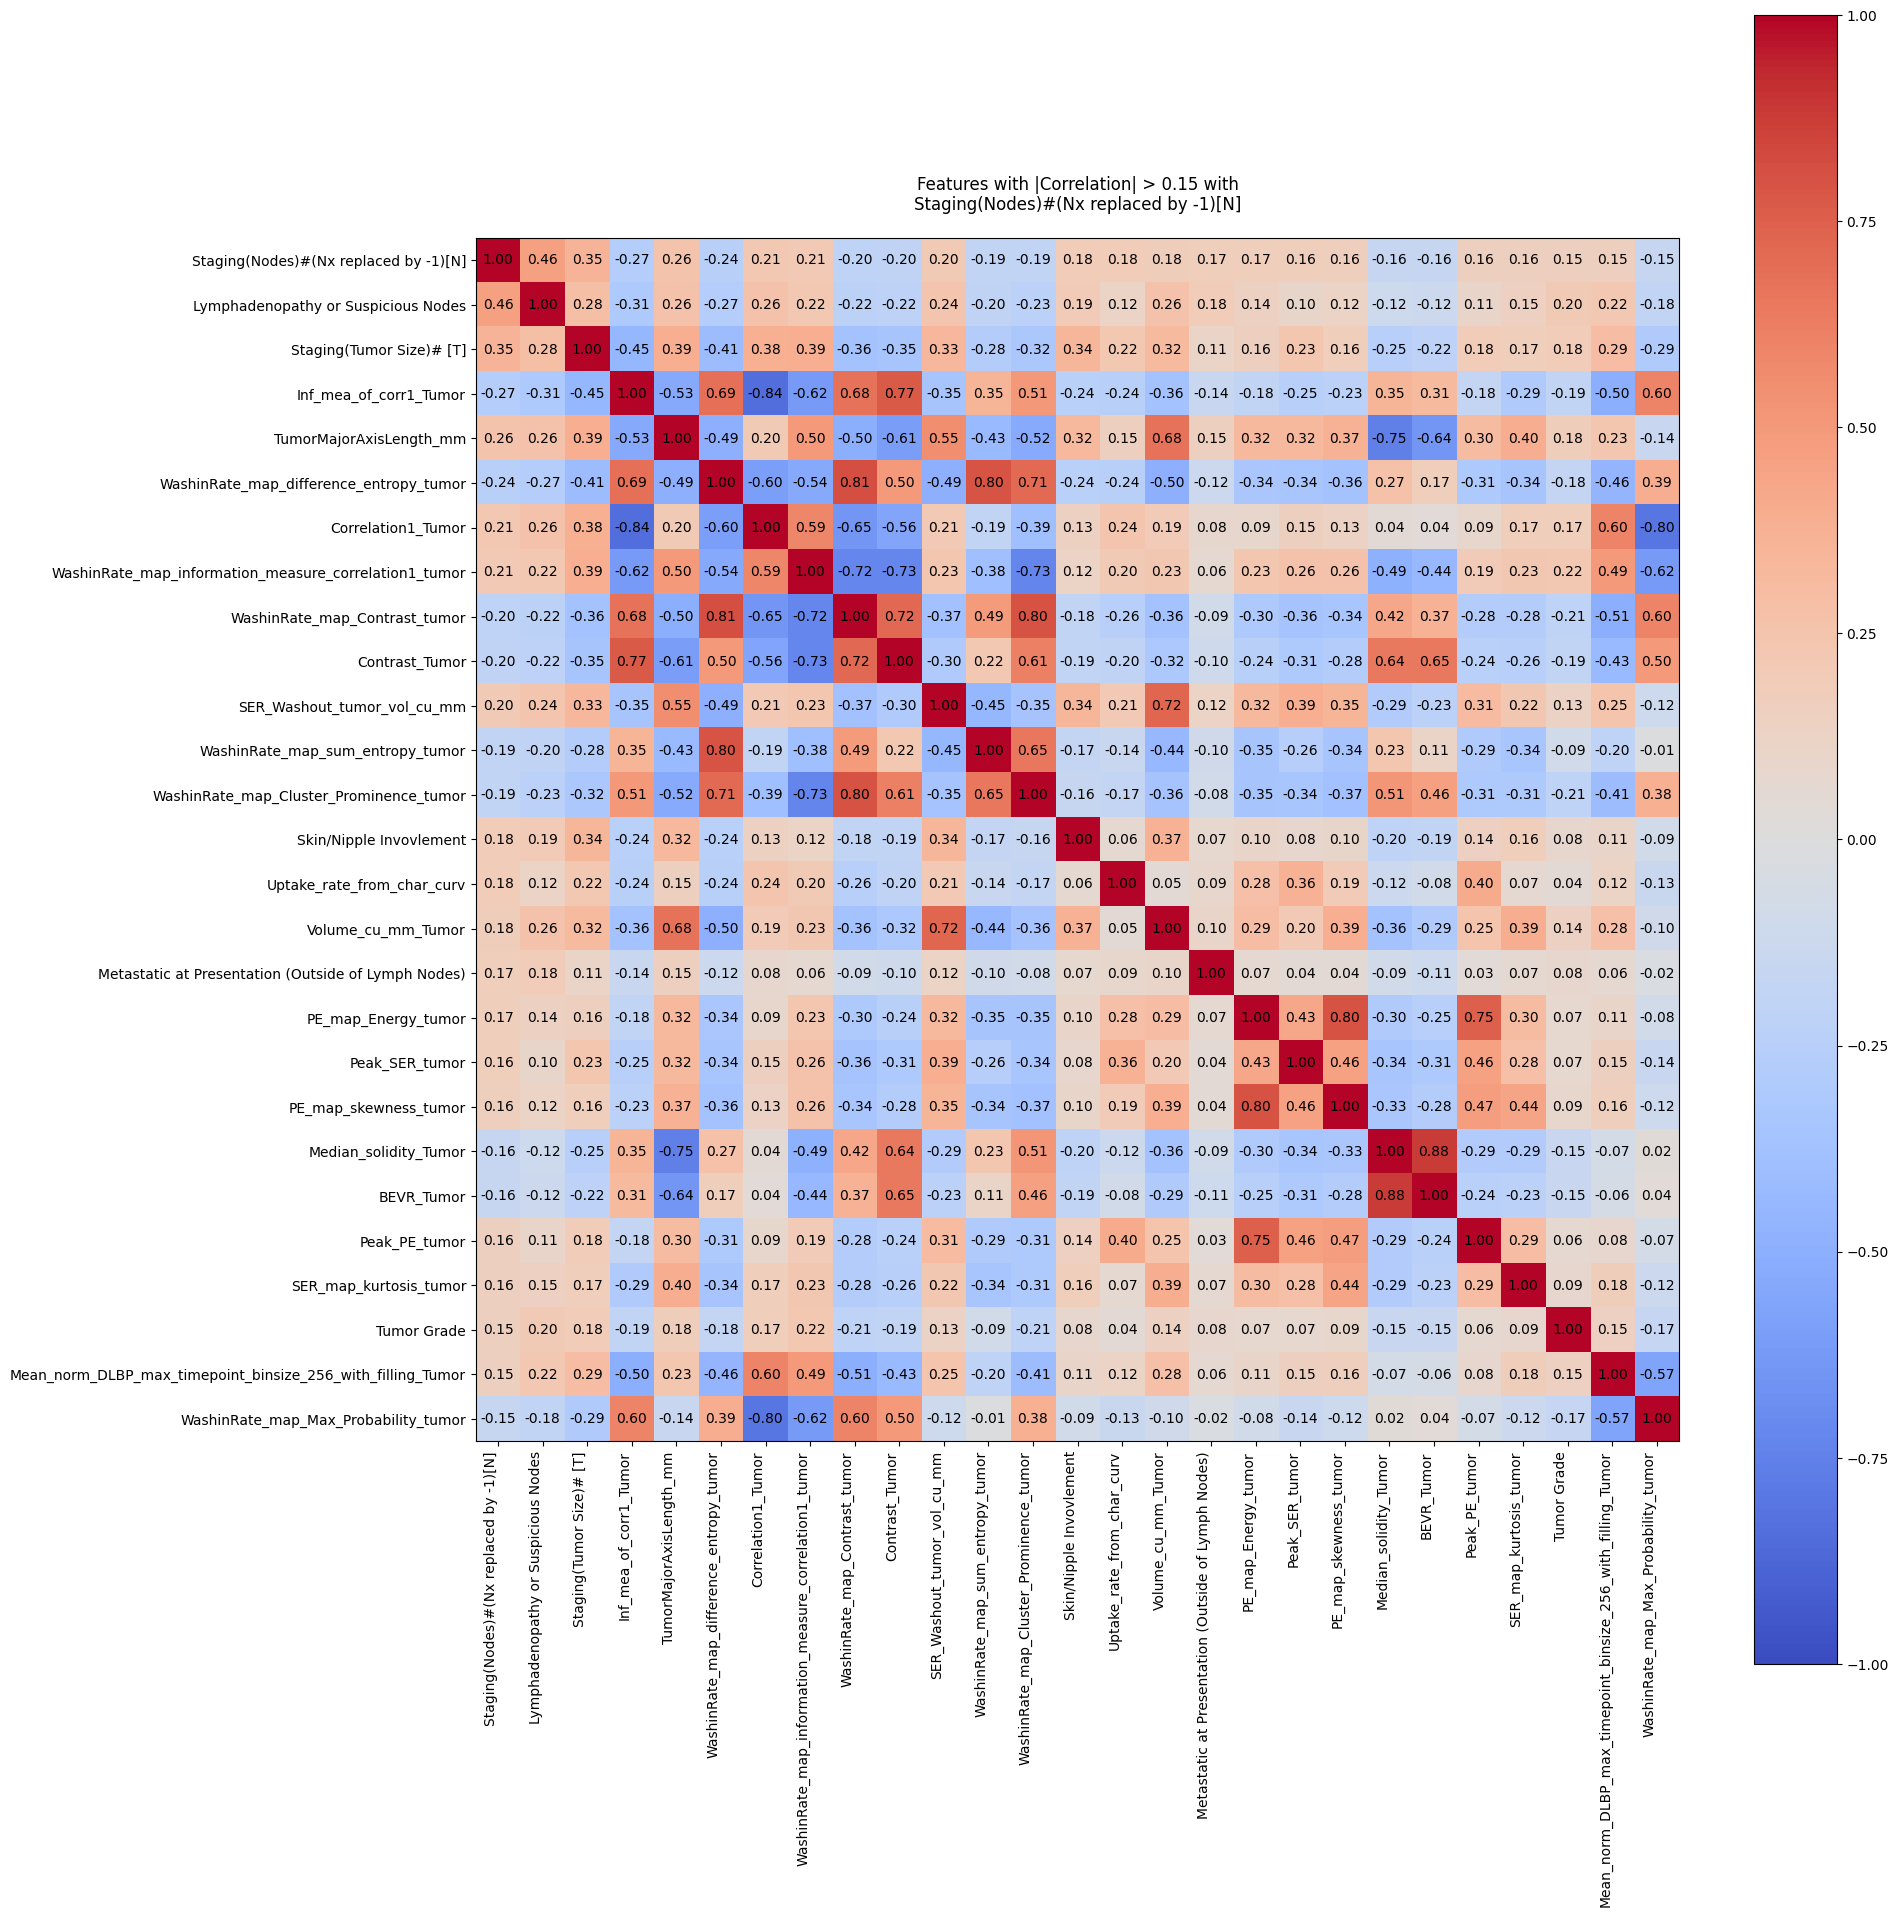

In [45]:
target = "Staging(Nodes)#(Nx replaced by -1)[N]"

# Compute correlation
corr_matrix = numerical_data[reduced_features].corr()
corr_abs = corr_matrix.abs()

# Filter features strongly correlated with target
relevant_features = corr_abs[corr_abs[target] > 0.15].index.tolist()

# Optional: sort by correlation strength (descending)
relevant_features = corr_abs[target].loc[relevant_features].sort_values(ascending=False).index.tolist()

# Subset matrix
subset_corr = corr_matrix.loc[relevant_features, relevant_features]

# Plot
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(subset_corr, cmap='coolwarm', vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(relevant_features)), labels=relevant_features, rotation=90, ha='right')
ax.set_yticks(np.arange(len(relevant_features)), labels=relevant_features)

# Annotate
for i in range(len(relevant_features)):
    for j in range(len(relevant_features)):
        ax.text(j, i, f"{subset_corr.iloc[i, j]:.2f}",
                ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax)
plt.title(f'Features with |Correlation| > 0.15 with\n{target}', pad=20)
plt.tight_layout()
plt.show()

'WashinRate' appears multiple times. Identify all the columns containing Wash in Rate

In [46]:
washin_cols = [col for col in reduced_features if 'WashinRate' in col]
print(washin_cols)
print(f"Found {len(washin_cols)} Wash in Rate columns")

['WashinRate_map_Max_Probability_tumor', 'WashinRate_map_information_measure_correlation1_tumor', 'WashinRate_map_Correlation1_tumor', 'WashinRate_map_Cluster_Prominence_tumor', 'WashinRate_map_Autocorrelation_tumor', 'WashinRate_map_Cluster_Shade_tissue_PostCon', 'WashinRate_map_sum_entropy_tumor', 'WashinRate_map_Contrast_tumor', 'WashinRate_map_kurtosis_tumor', 'WashinRate_map_difference_entropy_tumor', 'WashinRate_map_mean_tissue_T1', 'WashinRate_map_Entropy_tumor', 'WashinRate_map_Autocorrelation_tissue_PostCon']
Found 13 Wash in Rate columns


In [47]:
SER_PE_cols = [col for col in reduced_features if 'SER_map' in col or 'PE_map' in col]
print(SER_PE_cols)
print(f"Found {len(SER_PE_cols)} SER, PE Maps columns")

['PE_map_Cluster_Prominence_tissue_T1', 'PE_map_Entropy_tumor', 'PE_map_kurtosis_tumor', 'PE_map_Autocorrelation_tumor', 'SER_map_kurtosis_tumor', 'SER_map_information_measure_correlation2_tumor', 'SER_map_kurtosis_tissue_PostCon', 'SER_map_mean_tumor', 'PE_map_skewness_tumor', 'SER_map_Entropy_tissue_PostCon', 'SER_map_Entropy_tumor', 'SER_map_Energy_tumor', 'SER_map_Dissimilarity_tumor', 'PE_map_Dissimilarity_tumor', 'PE_map_mean_tumor', 'PE_map_Cluster_Prominence_tumor', 'PE_map_Energy_tumor', 'PE_map_information_measure_correlation2_tumor', 'SER_map_Cluster_Prominence_tumor', 'PE_map_Contrast_tissue_T1']
Found 20 SER, PE Maps columns


We want to identify and remove the highest related 'WashinRate' features. Same with 'SER' and 'PE' Maps. All these features are likely to be highly related. PCA is ideal for large amounts of correlated features.

**Principle Component Analysis(PCA)** for PER and SE Maps

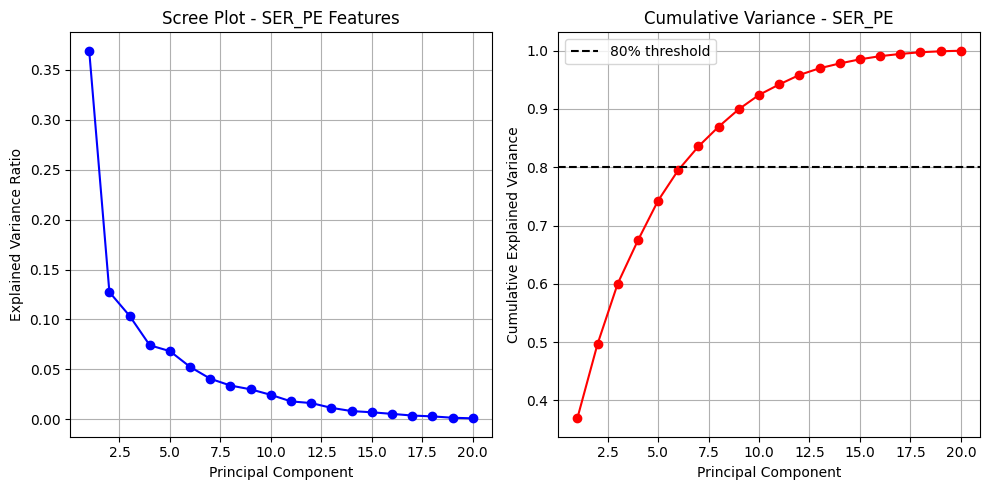


SER_PE PCA:
Number of components for 80% variance: 7
Original features: 20
Reduction: 13 features
Variance explained: 0.8358
Shape after SER_PE PCA: (922, 75)


In [87]:
numerical_data_reduced = numerical_data[reduced_features]
ser_pe = numerical_data[SER_PE_cols]  # Extract from original data

# Apply PCA
pca = PCA()
pca_features = pca.fit_transform(ser_pe)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - SER_PE Features')
plt.grid(True)

plt.subplot(1, 2, 2)
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumsum_var, 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance - SER_PE')
plt.axhline(y=0.80, color='k', linestyle='--', label='80% threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Determine optimal number of components (80% variance)
n_components = np.argmax(cumsum_var >= 0.80) + 1
print(f"\nSER_PE PCA:")
print(f"Number of components for 80% variance: {n_components}")
print(f"Original features: {len(SER_PE_cols)}")
print(f"Reduction: {len(SER_PE_cols) - n_components} features")
print(f"Variance explained: {cumsum_var[n_components-1]:.4f}")

# Create PCA features
pca_optimal = PCA(n_components=n_components)
ser_pe_pca = pca_optimal.fit_transform(ser_pe)

# Add PCA components to dataframe
numerical_data_reduced = numerical_data_reduced.copy()
for i in range(n_components):
    numerical_data_reduced[f'ser_pe_PC{i+1}'] = ser_pe_pca[:, i]

# Drop original SER PE Map features
numerical_data_reduced = numerical_data_reduced.drop(columns=SER_PE_cols)

print(f"Shape after SER_PE PCA: {numerical_data_reduced.shape}")


**Principle Component Analysis(PCA)** for Wash in Rate

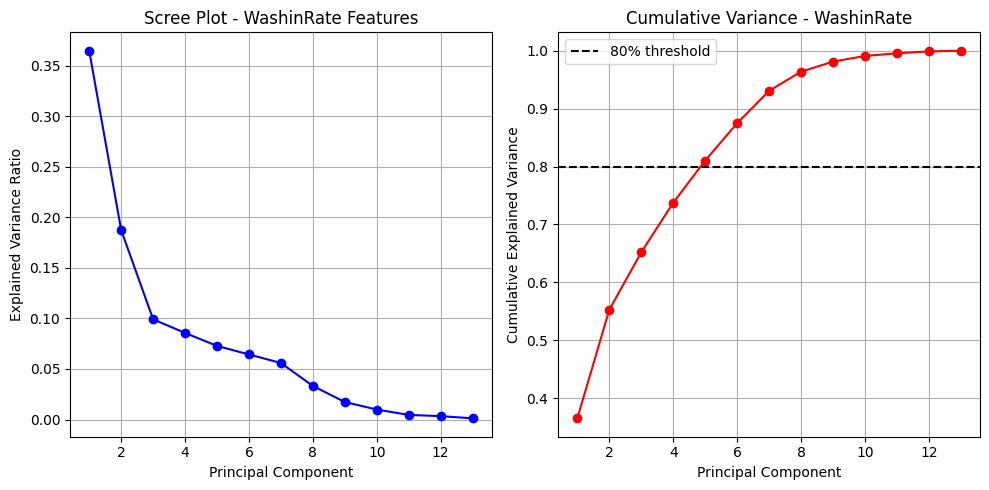


WashinRate PCA:
Number of components for 80% variance: 5
Original features: 13
Reduction: 8 features
Variance explained: 0.8103
Dropped 13 WashinRate columns

Final shape of numerical_data_reduced: (922, 67)
Total features: 67


In [88]:
washin = numerical_data[washin_cols]  # Extract from original data

# Apply PCA
pca = PCA()
pca_features = pca.fit_transform(washin)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - WashinRate Features')
plt.grid(True)

plt.subplot(1, 2, 2)
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumsum_var, 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance - WashinRate')
plt.axhline(y=0.80, color='k', linestyle='--', label='80% threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Determine optimal number of components (80% variance)
n_components = np.argmax(cumsum_var >= 0.80) + 1
print(f"\nWashinRate PCA:")
print(f"Number of components for 80% variance: {n_components}")
print(f"Original features: {len(washin_cols)}")
print(f"Reduction: {len(washin_cols) - n_components} features")
print(f"Variance explained: {cumsum_var[n_components-1]:.4f}")

# Create PCA features
pca_optimal = PCA(n_components=n_components)
washin_pca = pca_optimal.fit_transform(washin)

# Add PCA components to dataframe
for i in range(n_components):
    numerical_data_reduced[f'WashinRate_PC{i+1}'] = washin_pca[:, i]

# Drop original WashinRate features
washin_cols_in_reduced = [col for col in washin_cols if col in numerical_data_reduced.columns]
if washin_cols_in_reduced:
    numerical_data_reduced = numerical_data_reduced.drop(columns=washin_cols_in_reduced)
    print(f"Dropped {len(washin_cols_in_reduced)} WashinRate columns")

print(f"\nFinal shape of numerical_data_reduced: {numerical_data_reduced.shape}")
print(f"Total features: {numerical_data_reduced.shape[1]}")

In [89]:
numerical_data_reduced

Tumor Location  \
0                 0   
1                 0   
2                 1   
3                 0   
4                 1   
..              ...   
917               1   
918               1   
919               1   
920               1   
921               0   

     Grouping_based_variance_of_washout_slope_3D_tissue_PostCon_Group_2  \
0                                            -0.387083                    
1                                            -0.376334                    
2                                             0.122794                    
3                                             0.865065                    
4                                            -0.395070                    
..                                                 ...                    
917                                          -0.383263                    
918                                          -0.305842                    
919                                          -0.389351                    
920                                          -0.354652                    
921                                          -0.286167                    

     Staging(Metastasis)#(Mx -replaced by -1)[M]  Skin/Nipple Invovlement  \
0                                            0.0                        0   
1                                            0.0                        0   
2                                            0.0                        0   
3                                            0.0                        0   
4                                            0.0                        0   
..                                           ...                      ...   
917                                          0.0                        1   
918                                          0.0                        0   
919                                          0.0                        0   
920                                         -1.0                        0   
921                                          0.0                        0   

     Cluster_Prominence_Tumor  Staging(Nodes)#(Nx replaced by -1)[N]  \
0                   -0.097689                                    1.0   
1                   -0.529238                                    0.0   
2                   -1.175463                                    1.0   
3                    0.943290                                    0.0   
4                   -0.302734                                    1.0   
..                        ...                                    ...   
917                  1.285573                                    2.0   
918                 -0.734591                                    0.0   
919                  2.022681                                    0.0   
920                  0.875341                                    1.0   
921                  0.463877                                    0.0   

     Correlation1_Tumor  Contrast_Tumor  \
0              0.607099       -0.113092   
1             -0.905026       -0.333360   
2             -1.429885       -0.579721   
3             -0.467016        1.498831   
4              0.134416        0.083114   
..                  ...             ...   
917            1.518338       -0.526727   
918           -0.792370       -0.437896   
919            0.099061        1.559531   
920            1.291129       -0.348792   
921           -0.718622        1.170305   

     Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_1  \
0                                             0.214135                     
1                                            -1.023768                     
2                                             0.569044                     
3                                            -0.179665                     
4                                            -0.306068                     
..                                                 ...          

In [90]:
numerical_data_reduced.corr()

Tumor Location  \
Tumor Location                                            1.000000   
Grouping_based_variance_of_washout_slope_3D_tis...       -0.009862   
Staging(Metastasis)#(Mx -replaced by -1)[M]               0.118182   
Skin/Nipple Invovlement                                  -0.034936   
Cluster_Prominence_Tumor                                  0.002560   
...                                                            ...   
WashinRate_PC1                                           -0.033727   
WashinRate_PC2                                           -0.010747   
WashinRate_PC3                                            0.022578   
WashinRate_PC4                                            0.087752   
WashinRate_PC5                                            0.000392   

                                                    Grouping_based_variance_of_washout_slope_3D_tissue_PostCon_Group_2  \
Tumor Location                                                                              -0.009862                    
Grouping_based_variance_of_washout_slope_3D_tis...                                           1.000000                    
Staging(Metastasis)#(Mx -replaced by -1)[M]                                                 -0.081189                    
Skin/Nipple Invovlement                                                                     -0.001869                    
Cluster_Prominence_Tumor                                                                    -0.057564                    
...                                                                                               ...                    
WashinRate_PC1                                                                              -0.090079                    
WashinRate_PC2                                                                              -0.017335                    
WashinRate_PC3                                                                              -0.002315                    
WashinRate_PC4                                                                               0.097370                    
WashinRate_PC5                                                                              -0.024799                    

                                                    Staging(Metastasis)#(Mx -replaced by -1)[M]  \
Tumor Location                                                                         0.118182   
Grouping_based_variance_of_washout_slope_3D_tis...                                    -0.081189   
Staging(Metastasis)#(Mx -replaced by -1)[M]                                            1.000000   
Skin/Nipple Invovlement                                                               -0.058501   
Cluster_Prominence_Tumor                                                              -0.010456   
...                                                                                         ...   
WashinRate_PC1                                                                         0.010549   
WashinRate_PC2                                                                        -0.064899   
WashinRate_PC3                                                                        -0.016275   
WashinRate_PC4                                                                        -0.037347   
WashinRate_PC5                                                                        -0.025754   

                                                    Skin/Nipple Invovlement  \
Tumor Location                                                    -0.034936   
Grouping_based_variance_of_washout_slope_3D_tis...                -0.001869   
Staging(Metastasis)#(Mx -replaced by -1)[M]                       -0.058501   
Skin/Nipple Invovlement                                            1.000000   
Cluster_Prominence_Tumor                                          -0.200339   
...                                                                     ...   
Wash

In [91]:
print(len(numerical_data_reduced.columns))
print(list(numerical_data_reduced.columns))

67
['Tumor Location', 'Grouping_based_variance_of_washout_slope_3D_tissue_PostCon_Group_2', 'Staging(Metastasis)#(Mx -replaced by -1)[M]', 'Skin/Nipple Invovlement', 'Cluster_Prominence_Tumor', 'Staging(Nodes)#(Nx replaced by -1)[N]', 'Correlation1_Tumor', 'Contrast_Tumor', 'Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_1', 'Nottingham grade', 'PR', 'F1_DT_T1NFS (T11=0.05,T12=0.5)', 'Shape.1', 'Peak_SER_tumor', 'Peak_PE_tumor', 'Median_solidity_Tumor', 'Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor', 'Cluster_Shade_Tumor', 'Echogenicity', 'F1_DT_T1NFS (T11=0.05,T12=0.8)', 'F1_DT_T1NFS (T11=0.2,T12=0.5)', 'F1_DT_POSTCON (T11=0.05,T12=0.8)', 'Change_in_variance_of_Uptake_Tumor', 'F1_DT_POSTCON (T11=0.05,T12=0.5)', 'MF_Tumor', 'Breast Density', 'Volume_cu_mm_Tumor', 'Lymphadenopathy or Suspicious Nodes', 'BEVR_Tumor', 'Variance_of_RGH_values_Tumor', 'Menopause (at diagnosis)', '2nd_DFT_CoeffMap_Momment_Invariant_1_3D_tumor', 'EnhancementClusterDiscontinui

In [92]:
feature_rankings = {}

for target in target_features:
    X = numerical_data_reduced.drop(columns=[target])
    y = numerical_data_reduced[target]
    model = RandomForestRegressor(random_state=42)

    model.fit(X, y)
    importances = model.feature_importances_

    # Rank features
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Store results
    feature_rankings[target] = importance_df

    print(f"\nTop 10 features for target '{target}':")
    print(importance_df.head(10).to_string(index=False))


Top 10 features for target 'Staging(Nodes)#(Nx replaced by -1)[N]':
                            Feature  Importance
Lymphadenopathy or Suspicious Nodes    0.215882
           Staging(Tumor Size)# [T]    0.038507
            TumorMajorAxisLength_mm    0.037720
                     WashinRate_PC2    0.031955
                     WashinRate_PC3    0.023930
                         ser_pe_PC4    0.023365
                         ser_pe_PC7    0.022785
                     Peak_SER_tumor    0.022036
                     WashinRate_PC1    0.019583
                         ser_pe_PC2    0.019054

Top 10 features for target 'Staging(Metastasis)#(Mx -replaced by -1)[M]':
                                                           Feature  Importance
               Metastatic at Presentation (Outside of Lymph Nodes)    0.206518
                     2nd_DFT_CoeffMap_Momment_Invariant_1_3D_tumor    0.031564
        Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_3    0.022715
Grouping_bas

In [114]:
final_features = [
    "Staging(Tumor Size)# [T]",
    "Staging(Nodes)#(Nx replaced by -1)[N]",
    "Staging(Metastasis)#(Mx -replaced by -1)[M]",
    "Age at mammo (days)",
    "Tumor Size (cm).1",
    "TumorMajorAxisLength_mm",
    "Tumor Location",
    "Menopause (at diagnosis)",
    "Volume_cu_mm_Tumor",
    "Lymphadenopathy or Suspicious Nodes",
    "Metastatic at Presentation (Outside of Lymph Nodes)",
    "Peak_SER_tumor",
    "Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_3",
    "WashinRate_PC2",
    "WashinRate_PC3",
    "ser_pe_PC4",
    "ser_pe_PC7",
    "Autocorrelation_Tumor",
    "Energy_Tumor",
    "Variance_of_RGH_values_Tumor",
    "Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor",
    "Echogenicity"
]

final_features_df = numerical_data_reduced[final_features]

# Restore Patient ID
final_features_df.insert(0, "Patient ID", patient_ids)
final_features_df.head()
# Note: This DF is standardized

Patient ID  Staging(Tumor Size)# [T]  \
0  Breast_MRI_001                         2   
1  Breast_MRI_002                         2   
2  Breast_MRI_003                         2   
3  Breast_MRI_004                         1   
4  Breast_MRI_005                         2   

   Staging(Nodes)#(Nx replaced by -1)[N]  \
0                                    1.0   
1                                    0.0   
2                                    1.0   
3                                    0.0   
4                                    1.0   

   Staging(Metastasis)#(Mx -replaced by -1)[M]  Age at mammo (days)  \
0                                          0.0                   53   
1                                          0.0                   53   
2                                          0.0                   15   
3                                          0.0                   53   
4                                          0.0                   53   

   Tumor Size (cm).1  TumorMajorAxisLength_mm  Tumor Location  \
0                 47                -0.350045               0   
1                 47                -0.066026               0   
2                 47                 0.153850               1   
3                 47                -0.833159               0   
4                 47                -0.159173               1   

   Menopause (at diagnosis)  Volume_cu_mm_Tumor  ...  \
0                         0           -0.181871  ...   
1                         0           -0.358187  ...   
2                         1           -0.309901  ...   
3                         1           -0.390900  ...   
4                         0            0.004069  ...   

   Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_3  WashinRate_PC2  \
0                                          -1.012349                 0.127075   
1                                           0.047367                -0.710700   
2                                           0.571278                 0.952658   
3                                           2.031160                 0.631998   
4                                           0.243855                 1.298645   

   WashinRate_PC3  ser_pe_PC4  ser_pe_PC7  Autocorrelation_Tumor  \
0       -0.892188   -1.575226    0.967382               0.370349   
1       -1.558617   -1.013297   -0.768589              -0.827389   
2       -0.060066    0.597856   -0.155033              -1.061083   
3       -0.543056    0.617780    0.294731               1.554014   
4        0.656504   -0.409745    0.564630               0.264635   

   Energy_Tumor  Variance_of_RGH_values_Tumor  \
0     -0.710243                     -0.473772   
1      0.605332                     -0.009675   
2      0.926769                     -0.363579   
3     -1.424826                      0.654742   
4     -0.818151                     -0.428730   

   Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor  Echogenicity  
0                                           1.099950                      14  
1                                          -1.617884                      14  
2                                          -1.370098                      14  
3                                          -0.672884                      14  
4                                           1.258657                      14  

[5 rows x 23 columns]

**Export Submission CSV**

**Favorite Features:**

Age at Mammograph

Tumor Size (cm).1

TumorMajorAxisLength_mm

Tumor Location

Menopause (at diagnosis)

Volume_cu_mm_Tumor

Staging(Tumor Size)# [T]

Lymphadenopathy or Suspicious Nodes

Metastatic at Presentation (Outside of Lymph Nodes)

Peak_SER_tumor

Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_3

WashinRate_PC2

WashinRate_PC3

ser_pe_PC4

Autocorrelation_Tumor

Energy_Tumor

Variance_of_RGH_values_Tumor

Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor

In [112]:
final_features_df.to_csv('D:/Breast_Cancer_Dataset/final_features.csv', index=False)

In [115]:
import os

# Check if the file exists
file_path = 'D:/Breast_Cancer_Dataset/final_features.csv'
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path) / 1024  # Size in KB
    print(f"✓ File saved successfully!")
    print(f"File size: {file_size:.2f} KB")
    print(f"Rows: {len(final_features_df)}")
    print(f"Columns: {len(final_features_df.columns)}")
else:
    print("✗ File not found")

✓ File saved successfully!
File size: 250.31 KB
Rows: 922
Columns: 23


Will incorporate different combinations of these features and choose the combination that shows strongest model performance. 

**Input Directory Format Example:**

Breast_Cancer_Dataset

------Duke-Breast-Cancer-MRI

-------------Breast_MRI_001

---------------------01-01-1990-NA-MRI BREAST BILATERAL WWO-97538

------------------------------------3.000000-ax dyn pre-93877

------------------------------------5.000000-ax dyn 1st pass-59529

------------------------------------8.000000-ax dyn 2nd pass-92755

------------------------------------11.000000-ax dyn 3rd pass-41458

------------------------------------14.000000-ax dyn 4th pass-47500

-------------------------------------------------1-001.dcm

-------------------------------------------------1-002.dcm

Image sequences should be of similar length.
Need to train/test split by patient AND seperate by sequence(Image sequence order matters). Each patient will have 5-7 seqeunces in the form of a 3D Tensor. Each patient will have a TNM label. Each patient will have tabular features. Label and features DO NOT differ by sequence. They differ by patient. 

**Dataset Feature Loading**

In [22]:
def load_features(feature_dir):
    tumor, node, metastasis = 'Staging(Tumor Size)# [T]', 'Staging(Nodes)#(Nx replaced by -1)[N]', 'Staging(Metastasis)#(Mx -replaced by -1)[M]'
    features_pd = pd.read_csv(feature_dir)
    # Get patient ID
    patient_id = features_pd['Patient ID']
    # Get label columns
    t = features_pd[tumor]
    n = features_pd[node]
    m = features_pd[metastasis]
    # Drop label columns
    features = features_pd.drop([tumor, node, metastasis], axis=1)
    # Combine labels into one DataFrame
    labels = pd.DataFrame({
        'Patient ID': patient_id,
        'T': t,
        'N': n,
        'M': m
    })
    # labels['T'] = labels['T'].round()
    # labels['N'] = labels['N'].round()
    # labels['M'] = labels['M'].round()
    return features, labels 

In [18]:
root_directory = r"C:\Users\gabe7\CSU Fullerton Dropbox\Gabriel Rodriguez\Breast_Cancer_Dataset"
feature_csv = "https://dl.dropboxusercontent.com/scl/fi/nxafq0q32lqbta8wuy8zc/final_features.csv?rlkey=6ll6olx5fig9io0v1l77ycvbr&st=qvvvyehy"
bb_dir = "https://dl.dropboxusercontent.com/scl/fi/rqcyed40xtibqr5z699et/Annotation_Boxes.xlsx?rlkey=hxj1xgnq8ic352po56rx10jy5&st=91xbap3h&dl=0"
bounding_boxes = pd.read_excel(bb_dir)
bounding_boxes.head()

Patient ID  Start Row  End Row  Start Column  End Column  Start Slice  \
0  Breast_MRI_001        234      271           308         341           89   
1  Breast_MRI_002        251      294           108         136           59   
2  Breast_MRI_003        351      412            82         139           96   
3  Breast_MRI_004        262      280           193         204           86   
4  Breast_MRI_005        188      213           138         178           76   

   End Slice  
0        112  
1         72  
2        108  
3         95  
4        122

In [26]:
# Load Feature DataFrames
features, labels = load_features(feature_csv)

**Create pandas dataframe for sequence folder paths.**

In [43]:
root_directory = r"C:\Users\gabe7\Downloads\Breast_MRI_Subset"
image_columns = ['Patient ID', 'Folder Path']
image_df = pd.DataFrame(columns=image_columns)
# 1 sequence folder in directory per patient
for sequence_folder in os.listdir(root_directory):
    sequence_path = os.path.join(root_directory, sequence_folder)
    # Each sequence folder contains about 50-200 DICOM images.
    match = re.search(r'(Breast_MRI_\d+)', sequence_folder)
    patient_id = match.group(1)
    # Create new row to append to image dataframe
    new_row = pd.DataFrame({'Patient ID': [patient_id],
                            'Folder Path': [sequence_path]})
    # Add row
    image_df.loc[len(image_df)] = [patient_id, sequence_path]

print(len(image_df))
image_df.head()

541


Patient ID                                        Folder Path
0  Breast_MRI_003  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...
1  Breast_MRI_004  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...
2  Breast_MRI_012  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...
3  Breast_MRI_018  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...
4  Breast_MRI_021  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...

In [97]:
patient_ids = image_df['Patient ID']
patient_ids

0      Breast_MRI_003
1      Breast_MRI_004
2      Breast_MRI_012
3      Breast_MRI_018
4      Breast_MRI_021
            ...      
536    Breast_MRI_918
537    Breast_MRI_919
538    Breast_MRI_920
539    Breast_MRI_921
540    Breast_MRI_922
Name: Patient ID, Length: 541, dtype: object

**Train Val Test Split**

70% Training

15% Validation

15% Testing

In [98]:
from sklearn.model_selection import train_test_split

In [205]:
# Stratify by Tumor labels
T_labels = labels.loc[labels['Patient ID'].isin(patient_ids), 'T']
T_labels


2      2
3      1
11     2
17     3
20     1
      ..
917    2
918    1
919    1
920    2
921    2
Name: T, Length: 541, dtype: int64

In [206]:
X_train_ids, X_test_ids = train_test_split(patient_ids, test_size=0.3, stratify=T_labels, shuffle=True, random_state=67)
X_test_ids, X_val_ids = train_test_split(X_test_ids, test_size=0.5, shuffle=True, random_state=67)

**Create Train, Validation, and Test dataframes to convert to dictionary**

In [207]:
X_train_ids

383    Breast_MRI_765
120    Breast_MRI_374
265    Breast_MRI_647
158    Breast_MRI_480
417    Breast_MRI_799
            ...      
286    Breast_MRI_668
55     Breast_MRI_166
12     Breast_MRI_045
35     Breast_MRI_115
358    Breast_MRI_740
Name: Patient ID, Length: 378, dtype: object

In [208]:
X_train = image_df.loc[image_df['Patient ID'].isin(X_train_ids), ['Patient ID', 'Folder Path']]
X_val = image_df.loc[image_df['Patient ID'].isin(X_val_ids), ['Patient ID', 'Folder Path']]
X_test = image_df.loc[image_df['Patient ID'].isin(X_test_ids), ['Patient ID', 'Folder Path']]

**Group Features, Bounding Boxes, and Features into 1 column as a list**

In [209]:
# Group bounding boxes by patient into a list
bbox_grouped = (
    bounding_boxes
    .set_index('Patient ID')          # Set patient as index
    .apply(lambda row: row.tolist(), axis=1)  # Convert each row to a single list
    .reset_index(name='Bounding Box')
)

bbox_grouped

Patient ID                   Bounding Box
0    Breast_MRI_001  [234, 271, 308, 341, 89, 112]
1    Breast_MRI_002   [251, 294, 108, 136, 59, 72]
2    Breast_MRI_003   [351, 412, 82, 139, 96, 108]
3    Breast_MRI_004   [262, 280, 193, 204, 86, 95]
4    Breast_MRI_005  [188, 213, 138, 178, 76, 122]
..              ...                            ...
917  Breast_MRI_918   [345, 395, 338, 395, 62, 85]
918  Breast_MRI_919  [285, 312, 369, 397, 98, 109]
919  Breast_MRI_920  [172, 193, 337, 355, 87, 101]
920  Breast_MRI_921  [328, 374, 404, 446, 97, 121]
921  Breast_MRI_922   [258, 270, 149, 164, 82, 92]

[922 rows x 2 columns]

In [210]:
features_grouped = (
    features
    .set_index('Patient ID')          # Set patient as index
    .apply(lambda row: row.tolist(), axis=1)  # Convert each row to a single list
    .reset_index(name='Features')
)

In [211]:
labels_grouped = (
    labels
    .set_index('Patient ID')          # Set patient as index
    .apply(lambda row: row.tolist(), axis=1)  # Convert each row to a single list
    .reset_index(name='Label')
)

**Aggregate all of the data into 1 dataframe**

In [212]:
# Merge features onto Training
X_train = pd.merge(X_train, bbox_grouped, on='Patient ID', how='left')
X_train = pd.merge(X_train, features_grouped, on='Patient ID', how='left')
X_train = pd.merge(X_train, labels_grouped, on='Patient ID', how='left')
X_train

Patient ID                                        Folder Path  \
0    Breast_MRI_004  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
1    Breast_MRI_012  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
2    Breast_MRI_024  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
3    Breast_MRI_027  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
4    Breast_MRI_032  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
..              ...                                                ...   
373  Breast_MRI_914  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
374  Breast_MRI_916  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
375  Breast_MRI_920  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
376  Breast_MRI_921  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
377  Breast_MRI_922  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   

                       Bounding Box  \
0      [262, 280, 193, 204, 86, 95]   
1      [239, 390, 296, 431, 47, 97]   
2      [391, 398, 198, 206, 89, 94]   
3        [187, 214, 71, 99, 82, 99]   
4    [339, 383, 335, 398, 110, 125]   
..                              ...   
373    [334, 401, 361, 418, 54, 86]   
374    [281, 308, 329, 355, 57, 70]   
375   [172, 193, 337, 355, 87, 101]   
376   [328, 374, 404, 446, 97, 121]   
377    [258, 270, 149, 164, 82, 92]   

                                              Features             Label  
0    [53.0, 47.0, -0.8331588761104357, 0.0, 1.0, -0...   [1.0, 0.0, 0.0]  
1    [53.0, 47.0, 3.306210984127812, 1.0, 0.0, 3.86...  [2.0, 2.0, -1.0]  
2    [53.0, 47.0, -1.0145461612897615, 0.0, 1.0, -0...  [1.0, 0.0, -1.0]  
3    [53.0, 47.0, -0.4476327479666077, 1.0, 0.0, -0...   [2.0, 0.0, 0.0]  
4    [25.0, 30.0, -0.0770426671881628, 1.0, 0.0, -0...   [2.0, 0.0, 0.0]  
..                                                 ...               ...  
373  [53.0, 47.0, 0.4761974157546625, 1.0, 0.0, 0.4...   [2.0, 0.0, 0.0]  
374  [53.0, 47.0, -0.6815062248554038, 1.0, 1.0, -0...   [1.0, 0.0, 0.0]  
375  [53.0, 47.0, -0.8576295574069207, 1.0, 1.0, -0...   [1.0, 0.0, 0.0]  
376  [53.0, 47.0, 0.0666731813549273, 1.0, 0.0, -0....  [2.0, 1.0, -1.0]  
377  [53.0, 47.0, -0.8754513426957473, 0.0, 1.0, -0...   [2.0, 0.0, 0.0]  

[378 rows x 5 columns]

In [213]:
# Merge features onto Validation 
X_val = pd.merge(X_val, bbox_grouped, on='Patient ID', how='left')
X_val = pd.merge(X_val, features_grouped, on='Patient ID', how='left')
X_val = pd.merge(X_val, labels_grouped, on='Patient ID', how='left')
X_val

Patient ID                                        Folder Path  \
0   Breast_MRI_003  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
1   Breast_MRI_021  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
2   Breast_MRI_023  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
3   Breast_MRI_033  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
4   Breast_MRI_038  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
..             ...                                                ...   
77  Breast_MRI_904  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
78  Breast_MRI_908  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
79  Breast_MRI_910  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
80  Breast_MRI_915  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
81  Breast_MRI_917  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   

                      Bounding Box  \
0     [351, 412, 82, 139, 96, 108]   
1    [324, 359, 73, 109, 114, 131]   
2    [114, 155, 340, 369, 93, 115]   
3    [295, 396, 101, 161, 82, 115]   
4   [255, 291, 370, 410, 121, 139]   
..                             ...   
77      [91, 160, 52, 116, 42, 87]   
78    [354, 385, 109, 136, 33, 49]   
79     [247, 304, 76, 126, 52, 98]   
80    [291, 384, 341, 402, 58, 88]   
81    [250, 363, 99, 207, 54, 134]   

                                             Features             Label  
0   [15.0, 47.0, 0.1538504288534585, 1.0, 1.0, -0....   [2.0, 1.0, 0.0]  
1   [53.0, 47.0, -0.3626086675459358, 0.0, 1.0, -0...  [1.0, 1.0, -1.0]  
2   [53.0, 47.0, -0.2873599687151942, 0.0, 0.0, -0...  [2.0, 0.0, -1.0]  
3   [53.0, 47.0, 1.059203285276685, 0.0, 1.0, -0.1...  [3.0, 1.0, -1.0]  
4   [53.0, 47.0, -0.0016272456019999, 1.0, 1.0, -0...   [2.0, 2.0, 1.0]  
..                                                ...               ...  
77  [53.0, 47.0, 1.8010574931959835, 1.0, 0.0, 0.4...   [1.0, 0.0, 0.0]  
78  [53.0, 47.0, -0.5073503970513707, 0.0, 1.0, -0...  [1.0, 0.0, -1.0]  
79  [53.0, 47.0, 0.2525054411554529, 0.0, 0.0, 0.0...   [2.0, 0.0, 0.0]  
80  [53.0, 47.0, 0.8254037243646789, 1.0, 0.0, 0.7...   [2.0, 1.0, 0.0]  
81  [53.0, 47.0, 2.3095685173681164, 0.0, 0.0, 2.1...  [2.0, 1.0, -1.0]  

[82 rows x 5 columns]

In [214]:
# Merge features onto Testing
X_test = pd.merge(X_test, bbox_grouped, on='Patient ID', how='left')
X_test = pd.merge(X_test, features_grouped, on='Patient ID', how='left')
X_test = pd.merge(X_test, labels_grouped, on='Patient ID', how='left')
X_test

Patient ID                                        Folder Path  \
0   Breast_MRI_018  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
1   Breast_MRI_046  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
2   Breast_MRI_055  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
3   Breast_MRI_061  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
4   Breast_MRI_096  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
..             ...                                                ...   
76  Breast_MRI_897  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
77  Breast_MRI_899  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
78  Breast_MRI_911  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
79  Breast_MRI_918  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   
80  Breast_MRI_919  C:\Users\gabe7\Downloads\Breast_MRI_Subset\Bre...   

                     Bounding Box  \
0   [109, 188, 84, 120, 144, 164]   
1    [99, 205, 77, 162, 102, 190]   
2    [246, 286, 110, 142, 58, 76]   
3    [257, 381, 78, 166, 61, 102]   
4    [208, 240, 122, 202, 32, 68]   
..                            ...   
76   [293, 305, 352, 358, 77, 83]   
77  [306, 420, 117, 198, 85, 113]   
78  [257, 346, 366, 418, 92, 106]   
79   [345, 395, 338, 395, 62, 85]   
80  [285, 312, 369, 397, 98, 109]   

                                             Features             Label  
0   [53.0, 47.0, 1.2028303787861565, 1.0, 1.0, -0....   [3.0, 0.0, 0.0]  
1   [53.0, 47.0, 3.018596324790752, 0.0, 1.0, 1.16...   [4.0, 1.0, 0.0]  
2   [25.0, 47.0, -0.200572511052563, 1.0, 1.0, -0....   [2.0, 1.0, 0.0]  
3   [53.0, 47.0, 1.2642158208680807, 0.0, 1.0, 0.5...   [3.0, 0.0, 0.0]  
4   [53.0, 47.0, 1.092319210446289, 1.0, 0.0, 0.01...   [1.0, 0.0, 0.0]  
..                                                ...               ...  
76  [53.0, 47.0, -0.985554847187202, 1.0, 1.0, -0....  [1.0, 0.0, -1.0]  
77  [25.0, 9.0, 0.607520591994278, 1.0, 0.0, -0.09...   [3.0, 0.0, 0.0]  
78  [53.0, 47.0, 0.7536603009895233, 1.0, 0.0, -0....   [2.0, 1.0, 0.0]  
79  [53.0, 47.0, -0.3260637627002601, 1.0, 1.0, 0....   [2.0, 2.0, 0.0]  
80  [53.0, 47.0, -0.5044802076709628, 1.0, 1.0, -0...   [1.0, 0.0, 0.0]  

[81 rows x 5 columns]

**Convert dataframe to dictionaries(Train, Validation, Test)**

In [218]:
X_train_dict = X_train.to_dict(orient='records')

In [219]:
X_val_dict = X_val.to_dict(orient='records')
X_test_dict = X_test.to_dict(orient='records')

**Save Train Val Test Split**

In [221]:
joblib.dump((X_train_dict, X_val_dict, X_test_dict), 'train_split.joblib')

['train_split.joblib']

In [24]:
sequence_one = subset_sequences[0]
sequence = sequence_one['image_paths']
print(sequence)

C:\Users\gabe7\Downloads\Breast_MRI_Subset\Breast_MRI_003-ax 3d dyn MP


**Save Subset**

In [25]:
# Save
joblib.dump(subset_sequences, "subset_sequence_data.joblib")

['subset_sequence_data.joblib']

In [10]:
# "D:\Breast_Cancer_Dataset\Duke-Breast-Cancer-MRI\Breast_MRI_001\01-01-1990-NA-MRI BREAST BILATERAL WWO-97538\3.000000-ax dyn pre-93877"
patient = sequences[0]  # Get sequence
sequence = patient['image_paths']
print(sequence)

['C:\\Users\\gabe7\\CSU Fullerton Dropbox\\Gabriel Rodriguez\\Breast_Cancer_Dataset\\Breast_MRI_003\\01-01-1990-MRI BREAST BILATERAL WWO-87435\\3.000000-ax t1-86304\\1-01.dcm', 'C:\\Users\\gabe7\\CSU Fullerton Dropbox\\Gabriel Rodriguez\\Breast_Cancer_Dataset\\Breast_MRI_003\\01-01-1990-MRI BREAST BILATERAL WWO-87435\\3.000000-ax t1-86304\\1-02.dcm', 'C:\\Users\\gabe7\\CSU Fullerton Dropbox\\Gabriel Rodriguez\\Breast_Cancer_Dataset\\Breast_MRI_003\\01-01-1990-MRI BREAST BILATERAL WWO-87435\\3.000000-ax t1-86304\\1-03.dcm', 'C:\\Users\\gabe7\\CSU Fullerton Dropbox\\Gabriel Rodriguez\\Breast_Cancer_Dataset\\Breast_MRI_003\\01-01-1990-MRI BREAST BILATERAL WWO-87435\\3.000000-ax t1-86304\\1-04.dcm', 'C:\\Users\\gabe7\\CSU Fullerton Dropbox\\Gabriel Rodriguez\\Breast_Cancer_Dataset\\Breast_MRI_003\\01-01-1990-MRI BREAST BILATERAL WWO-87435\\3.000000-ax t1-86304\\1-05.dcm', 'C:\\Users\\gabe7\\CSU Fullerton Dropbox\\Gabriel Rodriguez\\Breast_Cancer_Dataset\\Breast_MRI_003\\01-01-1990-MRI BREA

**Preprocessed Sequence Visualization**

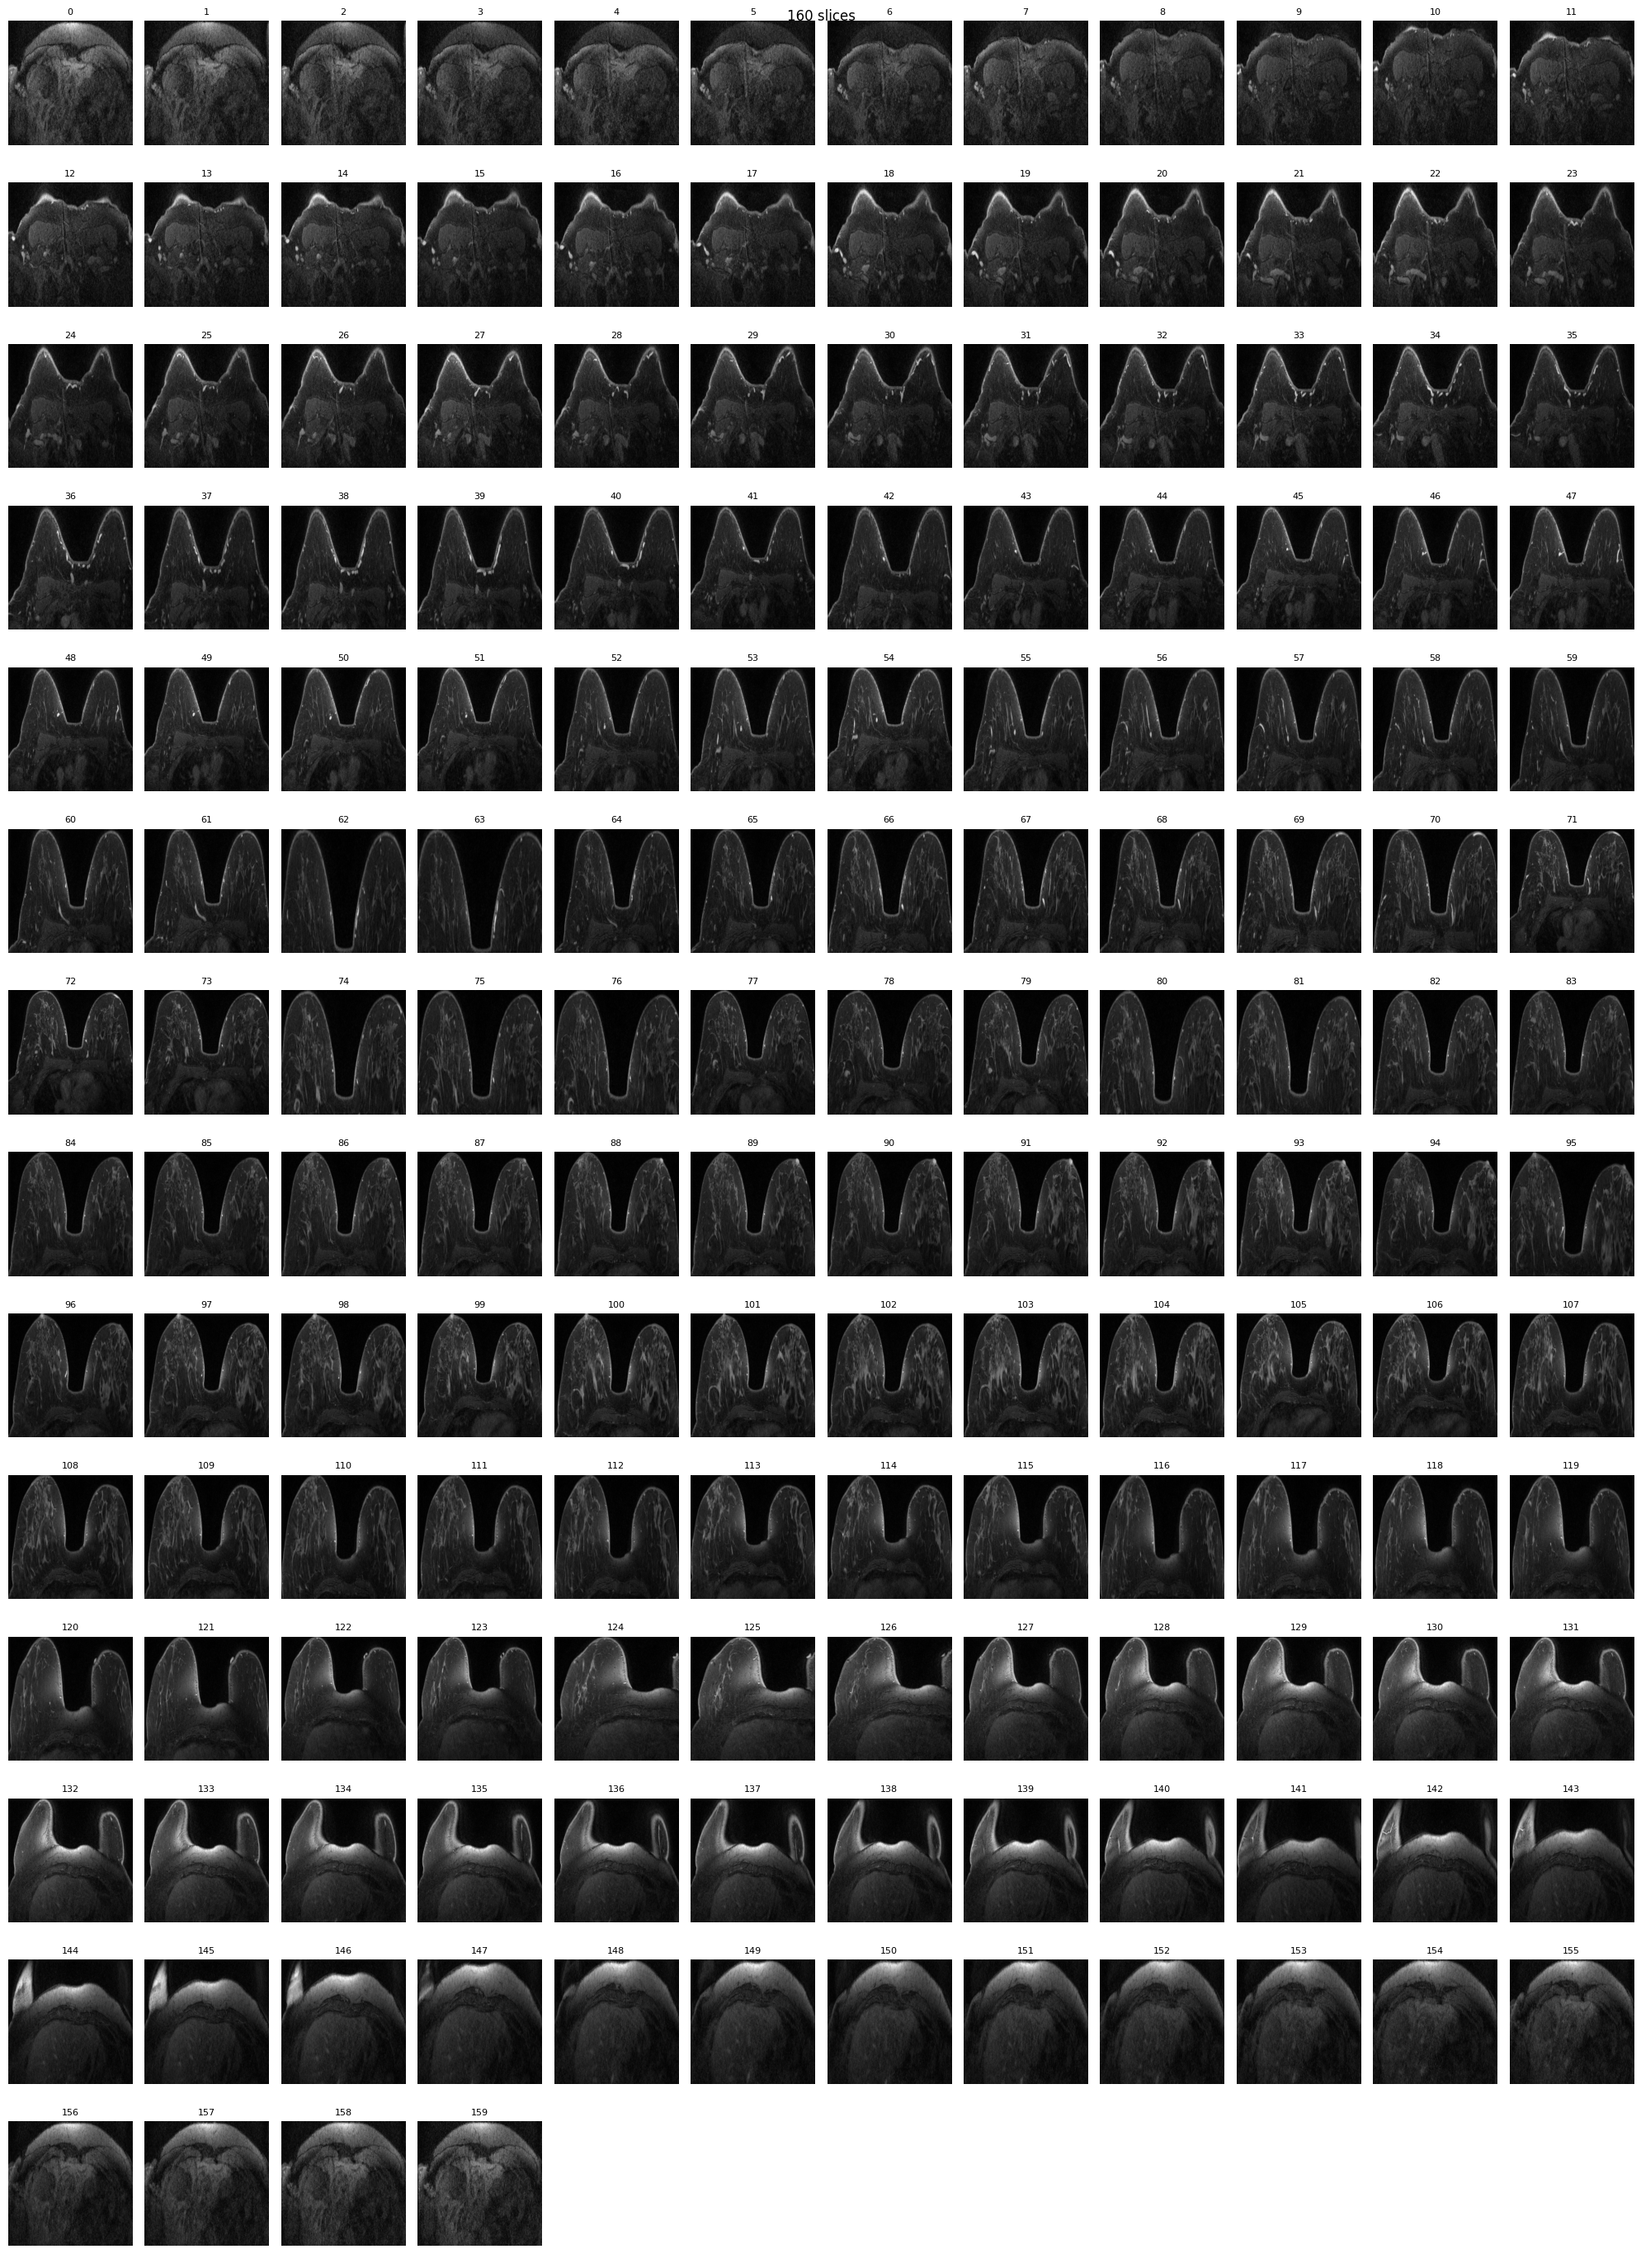

In [158]:
n_slices = len(sequence)
n_cols = 12  
n_rows = int(np.ceil(n_slices / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < n_slices:
        axes[i].imshow(sequence[i], cmap='gray')
        axes[i].set_title(f'{i}', fontsize=8)
    axes[i].axis('off')
    
plt.suptitle(f'{n_slices} slices')
plt.tight_layout()
plt.show()